# Random Forest Regressor Analysis

**Project Summary:**
The primary goal of the analysis is to design an accurate predictive model using the random forest regressor. Addressing Initial Days identifies the target response variable while explanatory variables are identified through the feature selection method using Select K Best. These selected features define the building blocks of the predictive model and metrics are optimized through
hyperparameter analysis using GridSearhCV. The results of the grid search tune the parameters of the random forest regressor and augment the performance of the machine learning model.
<br><br>

**Research Question:**
Can a Random Forest regressor accurately predict Initial Days (length of hospital stay)?
<br><br>
## **Table of Contents**
1. [Importing Dataset](#import-data)

2. [Preprocessing](#pre)

3. [Model Preperation](#model-prep)

4. [Model Refining](#model-tune)

5. [Random Forest Regressor Model](#model)

6. [Results](#results)

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="import-data"></a>

# Import Dataset
- Rename itemized features to corresponding names in data dictionary
- View first few rows of data
- Look for duplicate records
- Search for any null values
- Explore data types

In [4]:
# Upload CSV file and create backup

data = pd.read_csv(r'/content/drive/MyDrive/data_files/medical_clean_d207_8_9.csv')

data_backup = data

# Rename Item columns to represent their corresponding survey category
data.rename(columns = {'Item1':'Timely_admission',
                       'Item2': 'Timely_treatment',
                       'Item3':'Timely_visits',
                       'Item4':'Reliability',
                       'Item5':'Options',
                       'Item6':'Hours_of_treatment',
                       'Item7':'Courteous_staff',
                       'Item8':'Listening_doctor'}, inplace = True)


# View first 3 rows of dataframe
data.head(3)


,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_of_treatment,Courteous_staff,Listening_doctor
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.40342,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.99812,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.19246,2,4,4,4,3,4,3,3


In [5]:
# Explore data before prepping for predictive modeling
# Confirm no duplicate entries for data by checking for unique patient ids

data['Customer_id'].duplicated().value_counts()

Customer_id
False    10000
Name: count, dtype: int64

In [6]:
# Search for null values
data.isnull().sum()

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

In [7]:
# Explore data types, identify target variable and explanatory variables
# Search df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

In [8]:
# Task 2 dataframe
t2 = data.copy(deep = True)


<a name="pre"></a>
# Preprocessing
- Create new dataframe, filter original datafame for only relevant features
- View histogram of target featrue, Initial Days
- View summary statistics


In [9]:
# Drop features not relevant to task

t2.drop(columns = ['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Lat', 'Lng', 'TimeZone', 'Job', 'Marital'], axis = 1, inplace = True)

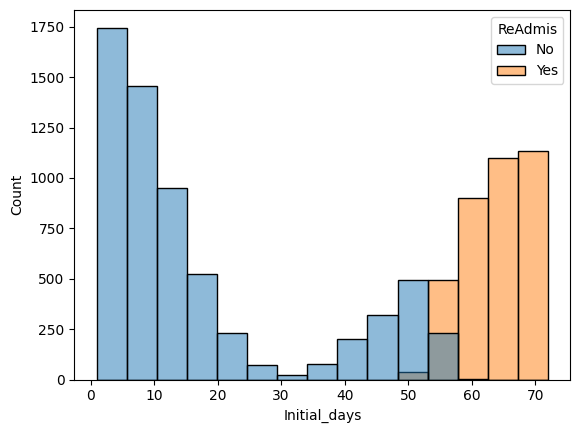

In [10]:
# Research question
# Can the random forest regressor be used to accurately predict Initial Days?

# Targeting initial days due to high level of readmissions over x days
# View histogram of initial days relative to readmission cases

sns.histplot(x = 'Initial_days', data = t2, hue = t2['ReAdmis']);

In [11]:
# Target response variable --- Initial Days
# View summary statistics before selecting variables for model
t2.describe()

# Numeric data to be left untreated for random forest regressor

,Zip,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_of_treatment,Courteous_staff,Listening_doctor
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50159.323900,9965.253800,2.097200,53.511700,40490.495160,17.964262,5.012200,1.001400,0.398900,34.455299,5312.172769,12934.528587,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,27469.588208,14824.758614,2.163659,20.638538,28521.153293,2.017231,1.045734,1.008117,0.628505,26.309341,2180.393838,6542.601544,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,610.000000,0.000000,0.000000,18.000000,154.080000,9.806483,1.000000,0.000000,0.000000,1.001981,1938.312067,3125.703000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27592.000000,694.750000,0.000000,36.000000,19598.775000,16.626439,4.000000,0.000000,0.000000,7.896215,3179.374015,7986.487755,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,50207.000000,2769.000000,1.000000,53.000000,33768.420000,17.951122,5.000000,1.000000,0.000000,35.836244,5213.952000,11573.977735,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,72411.750000,13945.000000,3.000000,71.000000,54296.402500,19.347963,6.000000,2.000000,1.000000,61.161020,7459.699750,15626.490000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,99929.000000,122814.000000,10.000000,89.000000,207249.100000,26.394449,9.000000,7.000000,5.000000,71.981490,9180.728000,30566.070000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [12]:
# Summary statistics of categorical data
# Look for binary variables to encode
t2.describe(include = 'object')

,Area,Gender,ReAdmis,Soft_drink,Initial_admin,HighBlood,Stroke,Complication_risk,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma,Services
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,3,3,2,2,3,2,2,3,2,2,2,2,2,2,2,2,2,4
top,Rural,Female,No,No,Emergency Admission,No,No,Medium,Yes,No,No,No,No,No,No,No,No,Blood Work
freq,3369,5018,6331,7425,5060,5910,8007,4517,7094,6426,7262,6628,5886,6785,6059,5865,7107,5265


In [13]:
# Backup original df and make new df for analysis
# Backup df
t2_backup = t2.copy(deep = True)

# df for analysis
df = t2.copy(deep = True)

<a name="model-prep"></a>
# Model Preperation
- Encode binary categorical variables to numeric
- Encode remaining categorical variables with dummies
- Calculate correlation coefficients and plot heatmap

In [14]:
# Encoding binary variables
# Binary features: Soft Drink, High Blood, Stroke, Overweight, Arthritis, Diabetes, Hyperlipidemia, Back Pain, Anxiety, Allergic Rhinitis, Reflux Esophagitis, and Asthma
binary_cols = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma' ]
binary_values = {'Yes': 1, 'No': 0}

for col in binary_cols:
  df[col] = df[col].replace(binary_values)

# Confirm binary encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Zip                 10000 non-null  int64  
 1   Population          10000 non-null  int64  
 2   Area                10000 non-null  object 
 3   Children            10000 non-null  int64  
 4   Age                 10000 non-null  int64  
 5   Income              10000 non-null  float64
 6   Gender              10000 non-null  object 
 7   ReAdmis             10000 non-null  int64  
 8   VitD_levels         10000 non-null  float64
 9   Doc_visits          10000 non-null  int64  
 10  Full_meals_eaten    10000 non-null  int64  
 11  vitD_supp           10000 non-null  int64  
 12  Soft_drink          10000 non-null  int64  
 13  Initial_admin       10000 non-null  object 
 14  HighBlood           10000 non-null  int64  
 15  Stroke              10000 non-null  int64  
 16  Compl

In [15]:
# View summary stats of remaining categorical types before one-hot encoding
# Area, Gender, Initial Admin, Complication Risk, and Services to be encoded

df.describe(include = 'object')

,Area,Gender,Initial_admin,Complication_risk,Services
count,10000,10000,10000,10000,10000
unique,3,3,3,3,4
top,Rural,Female,Emergency Admission,Medium,Blood Work
freq,3369,5018,5060,4517,5265


In [16]:
# Loop to create dummy variables
for col in df:
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns = [col], prefix = col)

# Confirm addition of dummies
df.head()

,Zip,Population,Children,Age,Income,ReAdmis,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,...,Initial_admin_Elective Admission,Initial_admin_Emergency Admission,Initial_admin_Observation Admission,Complication_risk_High,Complication_risk_Low,Complication_risk_Medium,Services_Blood Work,Services_CT Scan,Services_Intravenous,Services_MRI
0,35621,2951,1,53,86575.93,0,19.141466,6,0,0,...,False,True,False,False,False,True,True,False,False,False
1,32446,11303,3,51,46805.99,0,18.940352,4,2,1,...,False,True,False,True,False,False,False,False,True,False
2,57110,17125,3,53,14370.14,0,18.057507,4,1,0,...,True,False,False,False,False,True,True,False,False,False
3,56072,2162,0,78,39741.49,0,16.576858,4,1,0,...,True,False,False,False,False,True,True,False,False,False
4,23181,5287,1,22,1209.56,0,17.439069,5,0,2,...,True,False,False,False,True,False,False,True,False,False


In [17]:
# Confirm all numeric data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Zip                                  10000 non-null  int64  
 1   Population                           10000 non-null  int64  
 2   Children                             10000 non-null  int64  
 3   Age                                  10000 non-null  int64  
 4   Income                               10000 non-null  float64
 5   ReAdmis                              10000 non-null  int64  
 6   VitD_levels                          10000 non-null  float64
 7   Doc_visits                           10000 non-null  int64  
 8   Full_meals_eaten                     10000 non-null  int64  
 9   vitD_supp                            10000 non-null  int64  
 10  Soft_drink                           10000 non-null  int64  
 11  HighBlood                    

In [18]:
# Calculate correlation values relative to target variable - Initial Days
# Dataframe correlations relative to Initial Days
df_corr = df.corr()['Initial_days']

In [19]:
# Sort correlations
correlations = df_corr.sort_values(ascending = False)
print(correlations)

Initial_days                           1.000000
TotalCharge                            0.987640
ReAdmis                                0.850862
Children                               0.022467
Complication_risk_Low                  0.019029
Arthritis                              0.018907
Population                             0.017469
BackPain                               0.017344
Age                                    0.016264
vitD_supp                              0.015974
Zip                                    0.013568
Reflux_esophagitis                     0.012237
Anxiety                                0.011908
Area_Urban                             0.010951
Initial_admin_Elective Admission       0.010040
Services_CT Scan                       0.007786
Services_MRI                           0.007692
Gender_Male                            0.006704
Services_Blood Work                    0.006272
Additional_charges                     0.004409
Gender_Nonbinary                       0

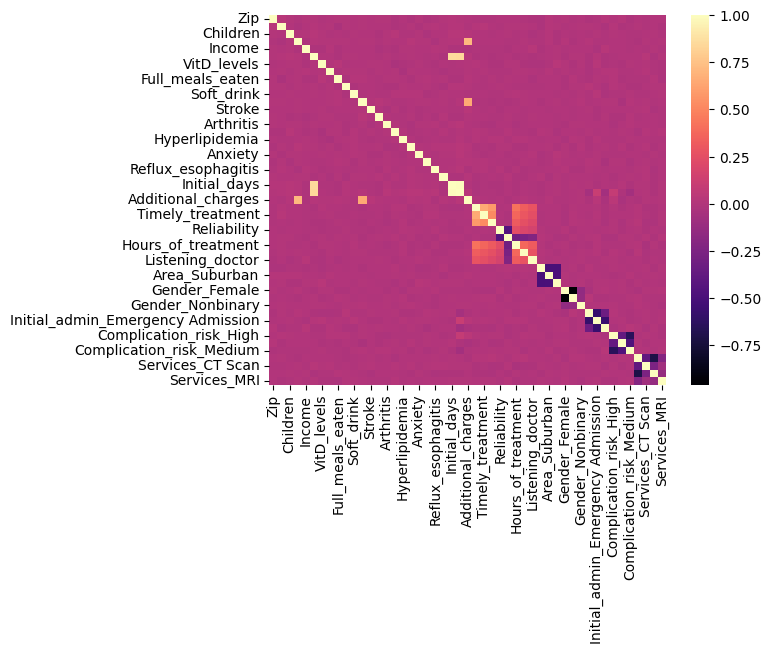

In [20]:
# Heatmap of correlations

sns.heatmap(df.corr(), cmap = 'magma');

In [21]:
# Feature selection for random forest analysis
# SELECT K BEST

# assign values for x and y
x_days = df.drop(['Initial_days'], axis = 1)
y_days = df['Initial_days']

print(x_days.shape)
print(y_days.shape)

(10000, 48)
(10000,)


<a name="model-tune"></a>
# Model Refining
- Use Select K Best to identify features relative to target feature, Readmissions
  - Retain features that measure below alpha or 0.05
- Create new dataframe with best features
- Use standard scaler to standardize data
- Use 70/30 train/test split for model training and validation
- Hyperparameter tuning with GridSearchCV


In [22]:
# Make SelectKBest model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

best = SelectKBest(score_func = f_regression, k = 'all')

days_best_model = best.fit_transform(x_days, y_days)


In [23]:
# Finding p-values --- Initial Days
features = x_days.columns

days_p_values = pd.DataFrame({'Feature': features, 'p_value': best.pvalues_}).sort_values('p_value')

print(days_p_values)

                                Feature   p_value
5                               ReAdmis  0.000000
22                          TotalCharge  0.000000
2                              Children  0.024661
24                     Timely_admission  0.026028
42                Complication_risk_Low  0.057062
14                            Arthritis  0.058668
1                            Population  0.080666
17                             BackPain  0.082861
8                      Full_meals_eaten  0.084232
3                                   Age  0.103879
9                             vitD_supp  0.110193
46                 Services_Intravenous  0.122847
0                                   Zip  0.174886
21                               Asthma  0.177187
4                                Income  0.212627
20                   Reflux_esophagitis  0.221123
18                              Anxiety  0.233762
29                   Hours_of_treatment  0.239953
27                          Reliability  0.240107


In [24]:
# View features that measure below alpha (0.05)
days_p_values[days_p_values['p_value'] < 0.05]


,Feature,p_value
5,ReAdmis,0.000000
22,TotalCharge,0.000000
2,Children,0.024661
24,Timely_admission,0.026028


In [25]:
# Print features to keep
# ALPHA level set to p < 0.05
days_features_to_keep = days_p_values['Feature'][days_p_values['p_value'] < 0.05]

print(days_features_to_keep)

5              ReAdmis
22         TotalCharge
2             Children
24    Timely_admission
Name: Feature, dtype: object


In [26]:
# Subset data frame to select statistically significant features from selectkbest
df_t2 = df[['Initial_days', 'ReAdmis', 'TotalCharge', 'Children', 'Timely_admission']]

df_t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Initial_days      10000 non-null  float64
 1   ReAdmis           10000 non-null  int64  
 2   TotalCharge       10000 non-null  float64
 3   Children          10000 non-null  int64  
 4   Timely_admission  10000 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


In [27]:
# Copy treated and select k best data fame for PA
# Export to csv file for pa
df_t2.to_csv(r'C:\Users\andrew\Desktop\WGU_MSDA\D209_Data_Mining\PA\Task 2\csv files\treated_model_data_task_2.csv')

df_t2.head(3)

,Initial_days,ReAdmis,TotalCharge,Children,Timely_admission
0,10.585770,0,3726.702860,1,3
1,15.129562,0,4193.190458,3,3
2,4.772177,0,2434.234222,3,2


In [28]:
# Train/Test split Post Select K Best
# Import train test split
# Stratify train test split based on readmissions
from sklearn.model_selection import train_test_split

# Define response and explanatory variables
X = df_t2.drop(['Initial_days'], axis = 1)
y = df_t2['Initial_days']

# Split response and explanatory variables into train and test sets
# Stratify to retain proportional response data representation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 61, stratify = X['ReAdmis'])

# Print shape of train/test sets
print('Train Set')
print(X_train.shape)
print(y_train.shape)
print('\n ----- \n')
print('Test Set')
print(X_test.shape)
print(y_test.shape)

Train Set
(7000, 4)
(7000,)

 ----- 

Test Set
(3000, 4)
(3000,)


In [29]:
# Compare percentages of readmissions of train test split
pct_readmis_train = X_train['ReAdmis'].value_counts() / (X_train['ReAdmis']).shape[0]
pct_readmis_test = X_test['ReAdmis'].value_counts() / (X_test['ReAdmis']).shape[0]

print("Percentages of Readmissions from Train Data: " + '\n' + str(pct_readmis_train))
print('\n ---------------------------- \n')
print("Percentages of Readmissions from Test Data: "  + '\n' + str(pct_readmis_test))

Percentages of Readmissions from Train Data: 
ReAdmis
0    0.633143
1    0.366857
Name: count, dtype: float64

 ---------------------------- 

Percentages of Readmissions from Test Data: 
ReAdmis
0    0.633
1    0.367
Name: count, dtype: float64


In [30]:
# Files for Performance Assessment
# Separate train and test set explanatory variables
x_train_pa = X_train.copy(deep = True)
x_test_pa = X_test.copy(deep = True)

# Make copy of response variables for y train/test
y_train_pa = y_train.copy(deep = True)
y_test_pa = y_test.copy(deep = True)

# Prep df's for concat
train_df = [y_train_pa, x_train_pa]
test_df = [y_test_pa, x_test_pa]

# Combine train/test for corresponding df's
train_data = pd.concat(train_df, axis = 1)
test_data = pd.concat(test_df, axis = 1)


In [31]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Instantiate regressor
rf = RandomForestRegressor(random_state = 61, n_jobs = -1)

In [32]:
# Employ GridSearchCV for hyperparameter tuning and Random Forest optimization
from sklearn.model_selection import GridSearchCV

# Define parameters, look for optimized max_depth, max_features, n_estimators
params = {'max_depth': [2, 3, 4, None], 'max_features': [2, 3, 4], 'n_estimators': [20, 40, 60, 80, 100]}

In [33]:
# Random Forests
# Employ random forest GridSearchCV using 5-fold cross validation
rf_cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)

# Fit model
grid_fit = rf_cv.fit(X_train, y_train)

# Print results
print("Best Parameters: " + str(grid_fit.best_params_))
print("Best Score: " + str(grid_fit.best_score_))

Best Parameters: {'max_depth': 4, 'max_features': 4, 'n_estimators': 80}
Best Score: 0.9834374354137998


<a name="model"></a>
# Model
- Instantiate random forest regressor
- Set random forest regressor parameters to optimized perfomance as found through GridSearchCV
- Fit model to train data
- Calculate model predictions
- Calculate accuracy scores based on test data set
- Compute confusion matrix and visualize

In [34]:
# Regression model after finding best parameters
# Define best regressor based on GridSearchCV results
# Best Parameters: {'max_depth': 4, 'max_features': 4, 'n_estimators': 80}

# Identify the best estimator
rf_best = grid_fit.best_estimator_


# Confirm best estimator
rf_best

RandomForestRegressor(max_depth=4, max_features=4, n_estimators=80, n_jobs=-1,
                      random_state=61)

In [35]:
# Fit best model
model = rf_best.fit(X_train, y_train)

# Best Predictions
predictions = model.predict(X_test)

In [36]:
# Training Set Results
from sklearn.metrics import r2_score

y_train_pred = model.predict(X_train)

train_r2 = r2_score(y_train, y_train_pred)

# R2 score
print("Train r-square score: %0.3f" % (train_r2))


Train r-square score: 0.984


In [37]:
# Calculations for mean absolute error --- train data
from sklearn.metrics import mean_absolute_error

train_mae = mean_absolute_error(y_train, y_train_pred)

print("Train Data Mean Absolute Error: %0.3f" % (train_mae))


Train Data Mean Absolute Error: 2.676


In [38]:
# Calculations for mean squared error --- train data
from sklearn.metrics import mean_squared_error as MSE

train_mse = MSE(y_train, y_train_pred)

print('Train Data Mean Squared Error: %0.3f' % (train_mse))


Train Data Mean Squared Error: 11.153


In [39]:
# Calculations for root mean squared error --- train data

train_rmse = train_mse**(1/2)

print('Train Data Root Mean Squared Error: %0.3f' % (train_rmse))

Train Data Root Mean Squared Error: 3.340


<a name="results"></a>
# Results
- Perfomance calculations:
   - R-squared score
   - Mean Absolute Error (MAE)
   - Mean Squared Error (MSE)
   - Root Mean Squared Error (RMSE)
   - Accuracy
- Compare train/test perfomance calculations
- Plot Actual vs. Predicted values
- Visualize decision tree with random forest best estimators
- Identify and plot feature importances


In [40]:
# Performance of training set
print("Train r-square score: %0.3f" % (train_r2))
print("Train Data Mean Absolute Error: %0.3f" % (train_mae))
print('Train Data Mean Squared Error: %0.3f' % (train_mse))
print('Train Data Root Mean Squared Error: %0.3f' % (train_rmse))

Train r-square score: 0.984
Train Data Mean Absolute Error: 2.676
Train Data Mean Squared Error: 11.153
Train Data Root Mean Squared Error: 3.340


In [41]:
# Input calculated accuracy into data frame
accuracy = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
accuracy

,Actual,Predicted
2007,4.694614,4.806160
8416,62.670210,60.696032
1602,3.905750,4.882674
7868,62.816580,57.765788
1576,22.054957,18.760116
...,...,...
3815,1.339058,2.564345
1860,6.071419,7.507846
4640,1.845217,2.564345
8866,41.566130,39.665723


In [42]:
# Calculations of r-square score --- test data

test_r2 = r2_score(y_test, predictions)

print("Test Data R2 Score: %0.3f" % (test_r2))


Test Data R2 Score: 0.983


In [43]:
# Calculations for mean absolute error --- test data

test_mae = mean_absolute_error(y_test, predictions)

print("Test Data Mean Absolute Error: %0.3f" % (test_mae))


Test Data Mean Absolute Error: 2.745


In [44]:
# Calculations for mean squared error --- test data

test_mse = MSE(y_test, predictions)

print('Test Data Mean Squared Error: %0.3f' % (test_mse))


Test Data Mean Squared Error: 11.641


In [45]:
# Calculations for root mean squared error --- test data

test_rmse = test_mse**(1/2)

print('Test Data Root Mean Squared Error: %0.3f' % (test_rmse))


Test Data Root Mean Squared Error: 3.412


In [56]:
# Summary of test data
print("Test Data R2 Score: %0.3f" % (test_r2))
print("Test Data Mean Absolute Error: %0.3f" % (test_mae))
print('Test Data Mean Squared Error: %0.3f' % (test_mse))
print('Test Data Root Mean Squared Error: %0.3f' % (test_rmse))

Test Data R2 Score: 0.983
Test Data Mean Absolute Error: 2.745
Test Data Mean Squared Error: 11.641
Test Data Root Mean Squared Error: 3.412


In [46]:
print("Train R-square: %0.3f" % (train_r2))
print("Test R-square: %0.3f" % (test_r2))

Train R-square: 0.984
Test R-square: 0.983


In [47]:
print("Train MAE: %0.3f" % (train_mae))
print("Test MAE: %0.3f" % (test_mae))

Train MAE: 2.676
Test MAE: 2.745


In [48]:
print("Train MSE: %0.3f" % (train_mse))
print("Test MSE: %0.3f" % (test_mse))

Train MSE: 11.153
Test MSE: 11.641


In [49]:
print("Train RMSE: %0.3f" % (train_rmse))
print("Test RMSE: %0.3f" % (test_rmse))

Train RMSE: 3.340
Test RMSE: 3.412


<ipython-input-60-9a03e800d1bc>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_test, hist = False, color = "r", label= "Actual Values");
<ipython-input-60-9a03e800d1bc>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions, hist = False, color = "b", label = "Pr

Text(0.5, 1.0, 'Actual vs Predicted Values for Initial Days')

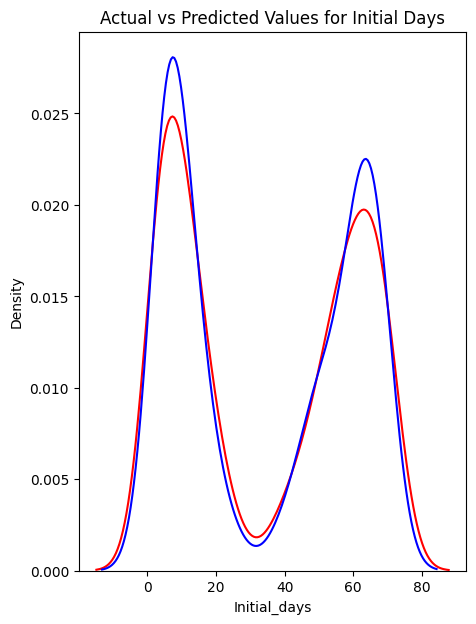

In [60]:
# Plot of actual and predictions
# Source (Kumar, 2020)

plt.figure(figsize=(5, 7))


ax = sns.distplot(y_test, hist = False, color = "r", label= "Actual Values");
sns.distplot(predictions, hist = False, color = "b", label = "Predicted Values" , ax=ax);
plt.title('Actual vs Predicted Values for Initial Days')



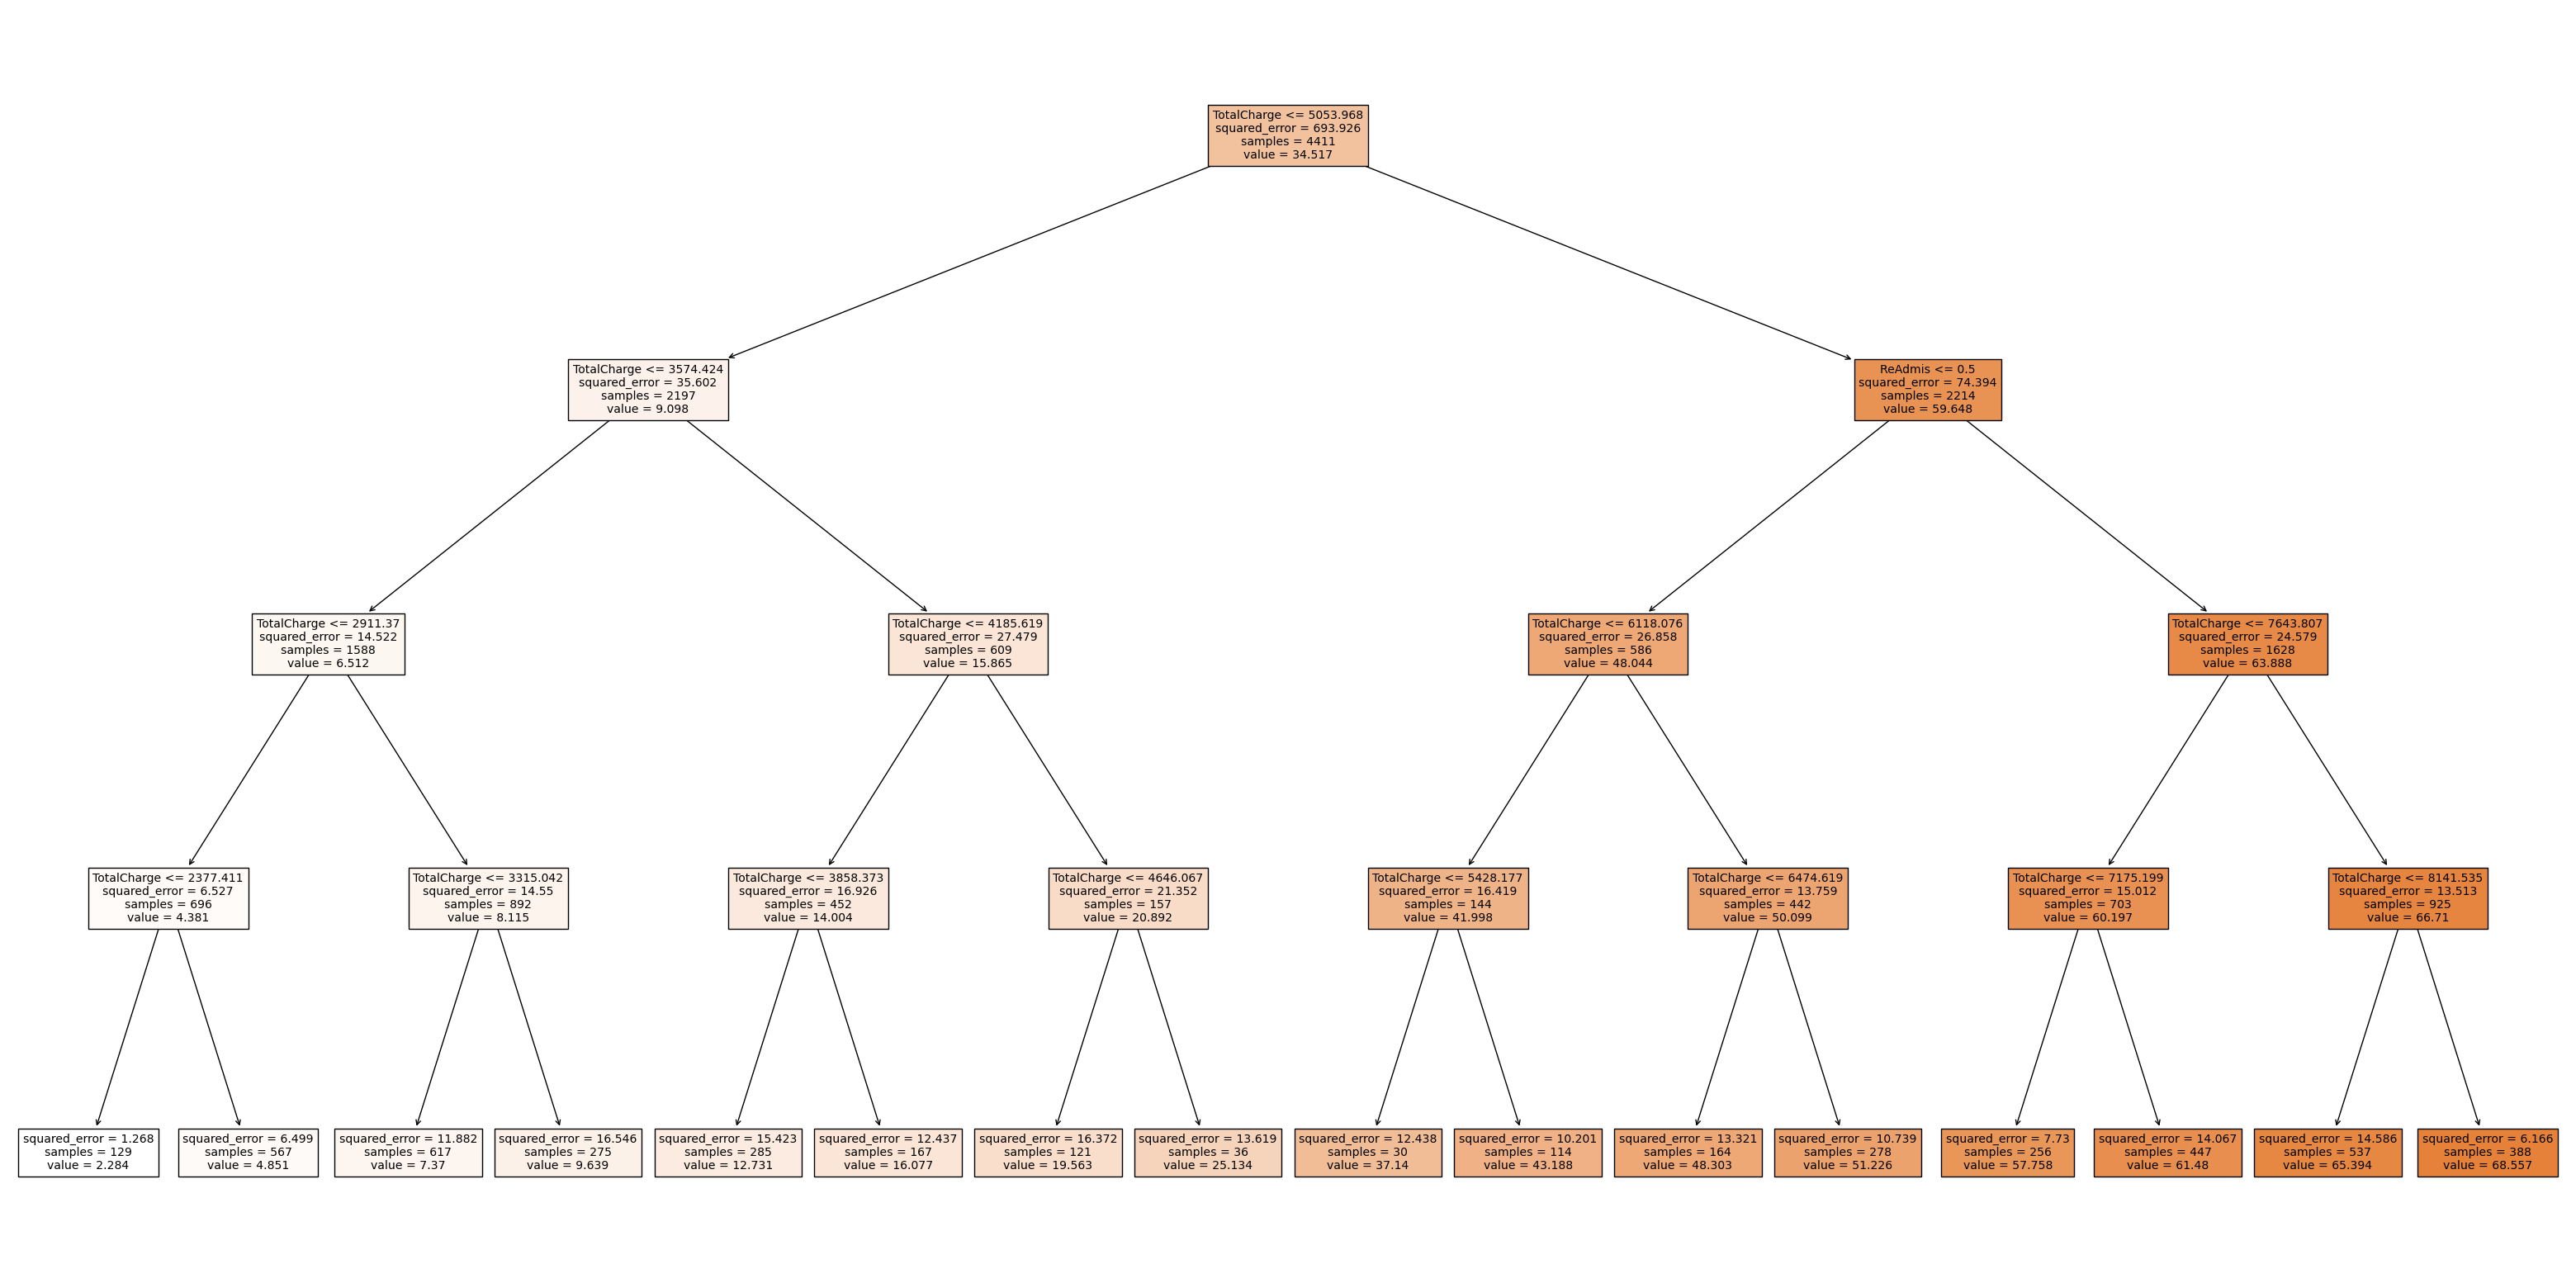

In [51]:
# Visualize decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
plot_tree(rf_best.estimators_[5], feature_names = X.columns,filled=True);

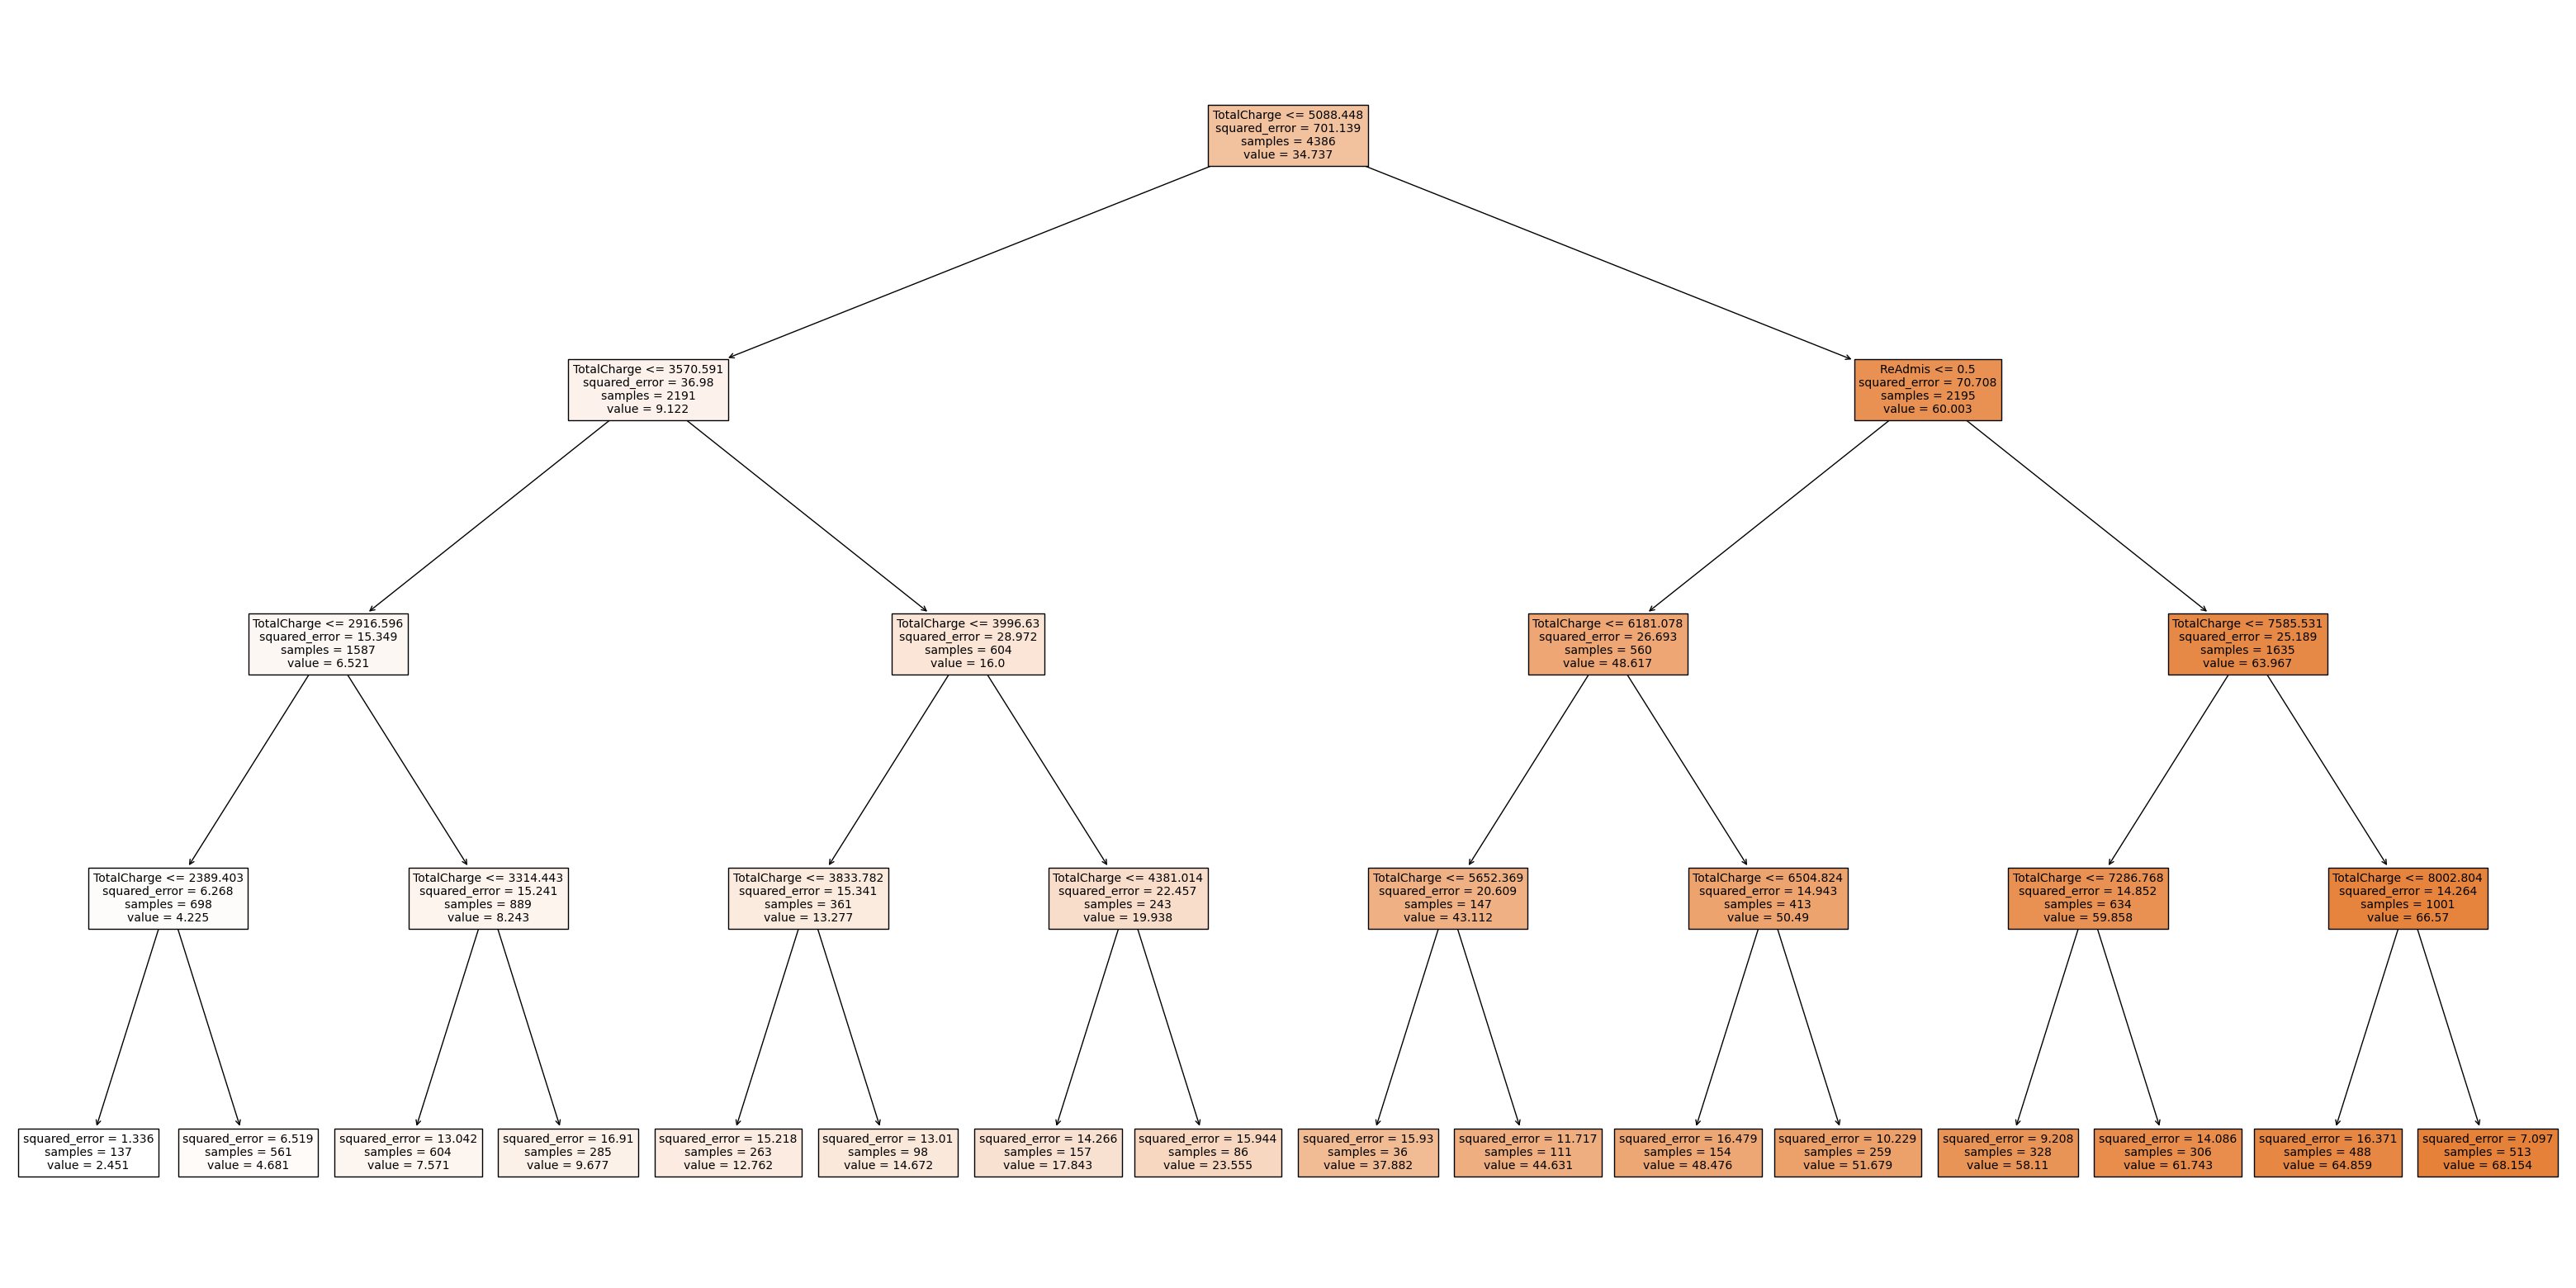

In [52]:
# Visualize decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(40,20))
plot_tree(rf_best.estimators_[7], feature_names = X.columns,filled=True);

In [53]:
#Feature importance

rf_importances = pd.Series(model.feature_importances_, index = X_train.columns)

# Sort importances
rf_sorted = rf_importances.sort_values(ascending = False)

print(rf_sorted)

TotalCharge         0.964764
ReAdmis             0.035236
Children            0.000000
Timely_admission    0.000000
dtype: float64


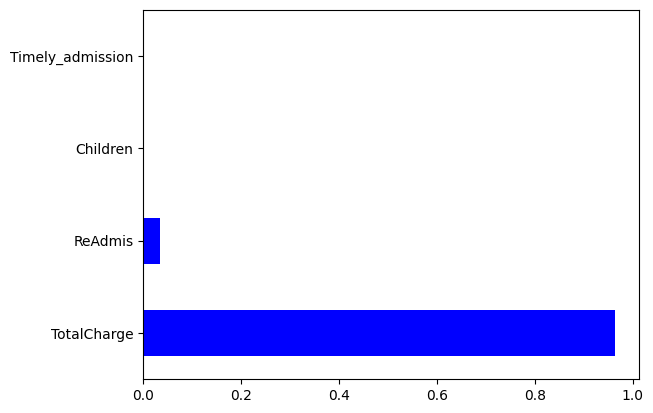

In [54]:
# Plot importances
rf_sorted.plot(kind = 'barh', color = 'blue')
plt.show()

In [55]:
#### END HERE ####